<a href="https://colab.research.google.com/github/MertYuksek/sine-wave-extrapolation/blob/main/Sine_Wave_Extrapolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [42]:
### import libraries
import torch
import torch.nn as nn
import numpy as np

# for printing out status reports
import sys

# for data visualization
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

# Create temporal sequence data

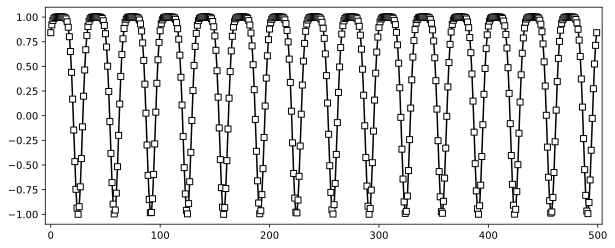

In [43]:
# create data
N = 500

time = torch.linspace(0, 30*np.pi, N)
data = torch.sin(time + torch.cos(time))

plt.figure(figsize=(10,4))
plt.plot(data,'ks-', markerfacecolor='w')
plt.xlim(-5, N+4)
plt.show()

# Create a class for the DL model

In [44]:
class rnnnet(nn.Module):
  def __init__(self,input_size,num_hidden,num_layers):
    super().__init__()

    # RNN Layer
    self.rnn = nn.RNN(input_size,num_hidden,num_layers)
    
    # linear layer for output
    self.out = nn.Linear(num_hidden,1)
  
  def forward(self,x,h):
    
    y,hidden = self.rnn(x,h)  
    y = self.out(y)
    
    return y,hidden.detach()

In [45]:
# network parameters
input_size = 1 # one data channel
num_hidden = 9 # number of units in hidden layers
num_layers = 1 # depth of model number of stacks of hidden layers
seqlength = 30 # number of data point used for learning in each segment
batchsize = 1

# create an instance of model
net = rnnnet(input_size, num_hidden, num_layers)

X = torch.rand(seqlength, batchsize, input_size) 
y, h = net(X,None)
print(f'Input shape: {list(X.shape)}') # 9x1x1
print(f'Hidden shape: {list(h.shape)}') # 1x1x5
# Note: this is one output per sequence element; generally we take the final output.
print(f'Output shape: {list(y.shape)}') # 9x1x1 it is not RNN-out (9x1x5).

Input shape: [30, 1, 1]
Hidden shape: [1, 1, 9]
Output shape: [30, 1, 1]


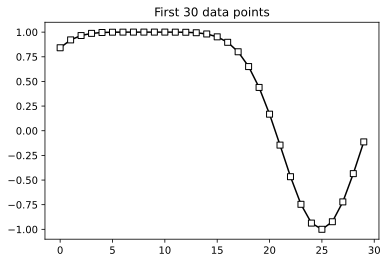

In [46]:
plt.plot(data[:seqlength],'ks-', markerfacecolor='w')
plt.title(f"First {seqlength} data points")
plt.show()

In [47]:
# test the model with some data
somedata = data[:seqlength].view(seqlength, 1, 1)
y = net(somedata,None)

finalValue = y[0][-1]
lossfun = nn.MSELoss()
lossfun(finalValue, data[seqlength].view(1,1))

tensor(0.0368, grad_fn=<MseLossBackward0>)

# Train the model and show performance

In [48]:
numepochs = 30

# create a new instance of the model and optimizer
net = rnnnet(input_size, num_hidden, num_layers)
optimizer = torch.optim.SGD(net.parameters(), lr=.001)
lossfun = nn.MSELoss()

# initialize losses
losses = np.zeros(numepochs)
signaccuracy = np.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over data segments
  seglosses = []
  segacc = []
  hidden_state = None # reset the hidden states not weights !!!!

  for timei in range(N - seqlength): 
    
    # grap a snippet of data
    X = data[timei:timei+seqlength].view(seqlength, 1, 1)  
    y = data[timei+seqlength].view(1, 1)                  
    # print(X.shape)
    # print(y.shape)

    # forward pass and loss
    yhat,hidden_state = net(X,None) 
    finalValue = yhat[-1]
    loss = lossfun(finalValue, y) # compare final value of output with real value

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss from this segment
    seglosses.append(loss.item())

  # average losses from this epoch
  losses[epochi] = np.mean(seglosses)

  msg = f'Finished epoch {epochi+1}/{numepochs}'
  sys.stdout.write('\r' + msg)

Finished epoch 30/30

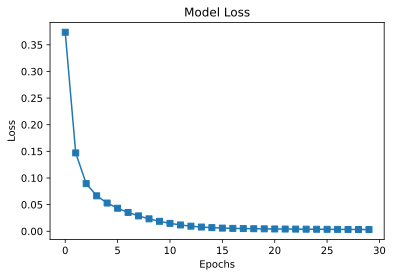

In [49]:
plt.plot(losses,'s-')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


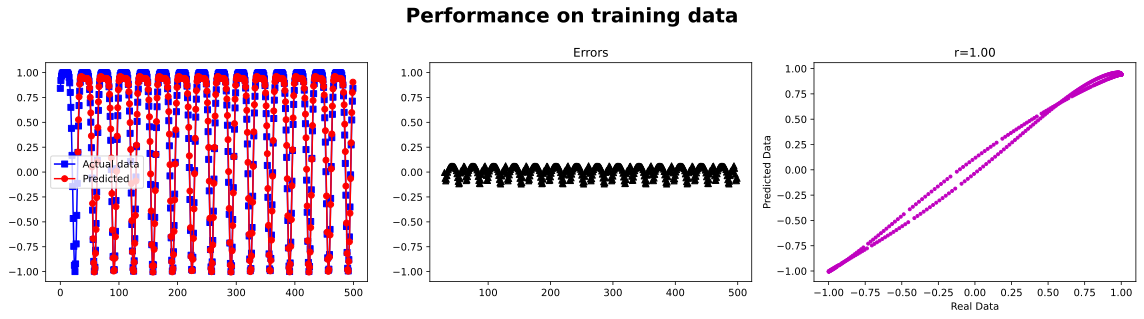

In [54]:
# Test model

# initalize hidden state
h = np.zeros((N,num_hidden))

# initialize predicted values
yHat = np.zeros(N)/0

hh = None
for timei in range(N - seqlength): # 41
    
    # grap a snippet of data
    X = data[timei:timei+seqlength].view(seqlength, 1, 1)  

    # forward pass and loss
    yy,hh = net(X,hh)
    yHat[timei+seqlength] = yy[-1]
    h[timei+seqlength,:] = hh.detach()

fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(data,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(data-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(data[seqlength:], yHat[seqlength:], 'mo', markersize=3)
ax[2].set_xlabel('Real Data')
ax[2].set_ylabel('Predicted Data')
r = np.corrcoef(data[seqlength:], yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f}")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  


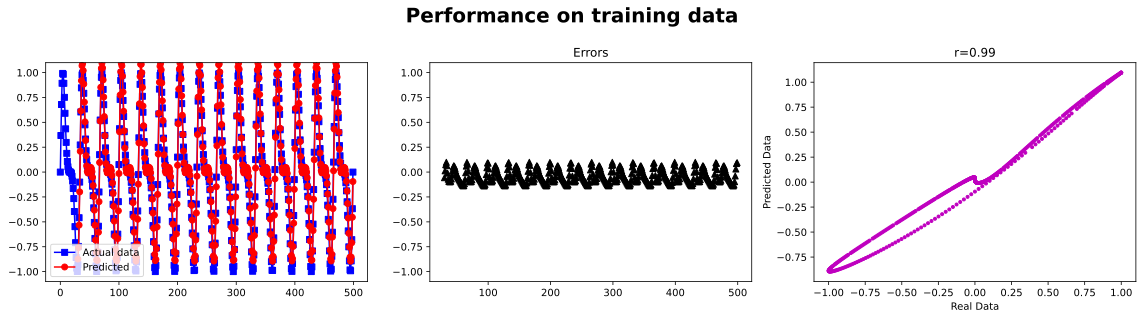

In [56]:
# time = torch.linspace(0, 10*np.pi, N)
# newdata = torch.sin(time + torch.cos(time))

time = torch.linspace(0, 30*np.pi, N)
newdata = torch.sin(time + torch.sin(time))

# initialize predicted values
yHat = np.zeros(N)/0

hh = None
for timei in range(N - seqlength): # 41
    
    # grap a snippet of data
    X = newdata[timei:timei+seqlength].view(seqlength, 1, 1)  

    # forward pass and loss
    yy,hh = net(X,hh)
    yHat[timei+seqlength] = yy[-1]

fig,ax = plt.subplots(1,3,figsize=(16,4))
ax[0].plot(newdata,'bs-',label='Actual data')
ax[0].plot(yHat,'ro-',label='Predicted')
ax[0].set_ylim([-1.1,1.1])
ax[0].legend()

ax[1].plot(newdata-yHat,'k^')
ax[1].set_ylim([-1.1,1.1])
ax[1].set_title('Errors')

ax[2].plot(newdata[seqlength:], yHat[seqlength:], 'mo', markersize=3)
ax[2].set_xlabel('Real Data')
ax[2].set_ylabel('Predicted Data')
r = np.corrcoef(newdata[seqlength:], yHat[seqlength:])
ax[2].set_title(f"r={r[0,1]:.2f}")

plt.suptitle('Performance on training data',fontweight='bold',fontsize=20,y=1.1)
plt.tight_layout()
plt.show()